In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
from warnings import filterwarnings
filterwarnings('ignore')
import os                                
import pandas as pd                     
import numpy as np                       
import random                           
import matplotlib.pyplot as plt         
import seaborn as sns                    
from termcolor import colored           
from PIL import Image                    
import tensorflow as tf                 
import keras   
sns.set_style('darkgrid')

In [2]:
base_dir  = os.path.expanduser('./dataset/archive')
print(os.listdir(base_dir))

train_dir =os.path.join(base_dir,'train')
test_dir=os.path.join(base_dir,'test')
classes=os.listdir(train_dir)
num_classes=len(classes)
print("the total number of classes present- ", num_classes)

['train', 'test']
the total number of classes present-  80


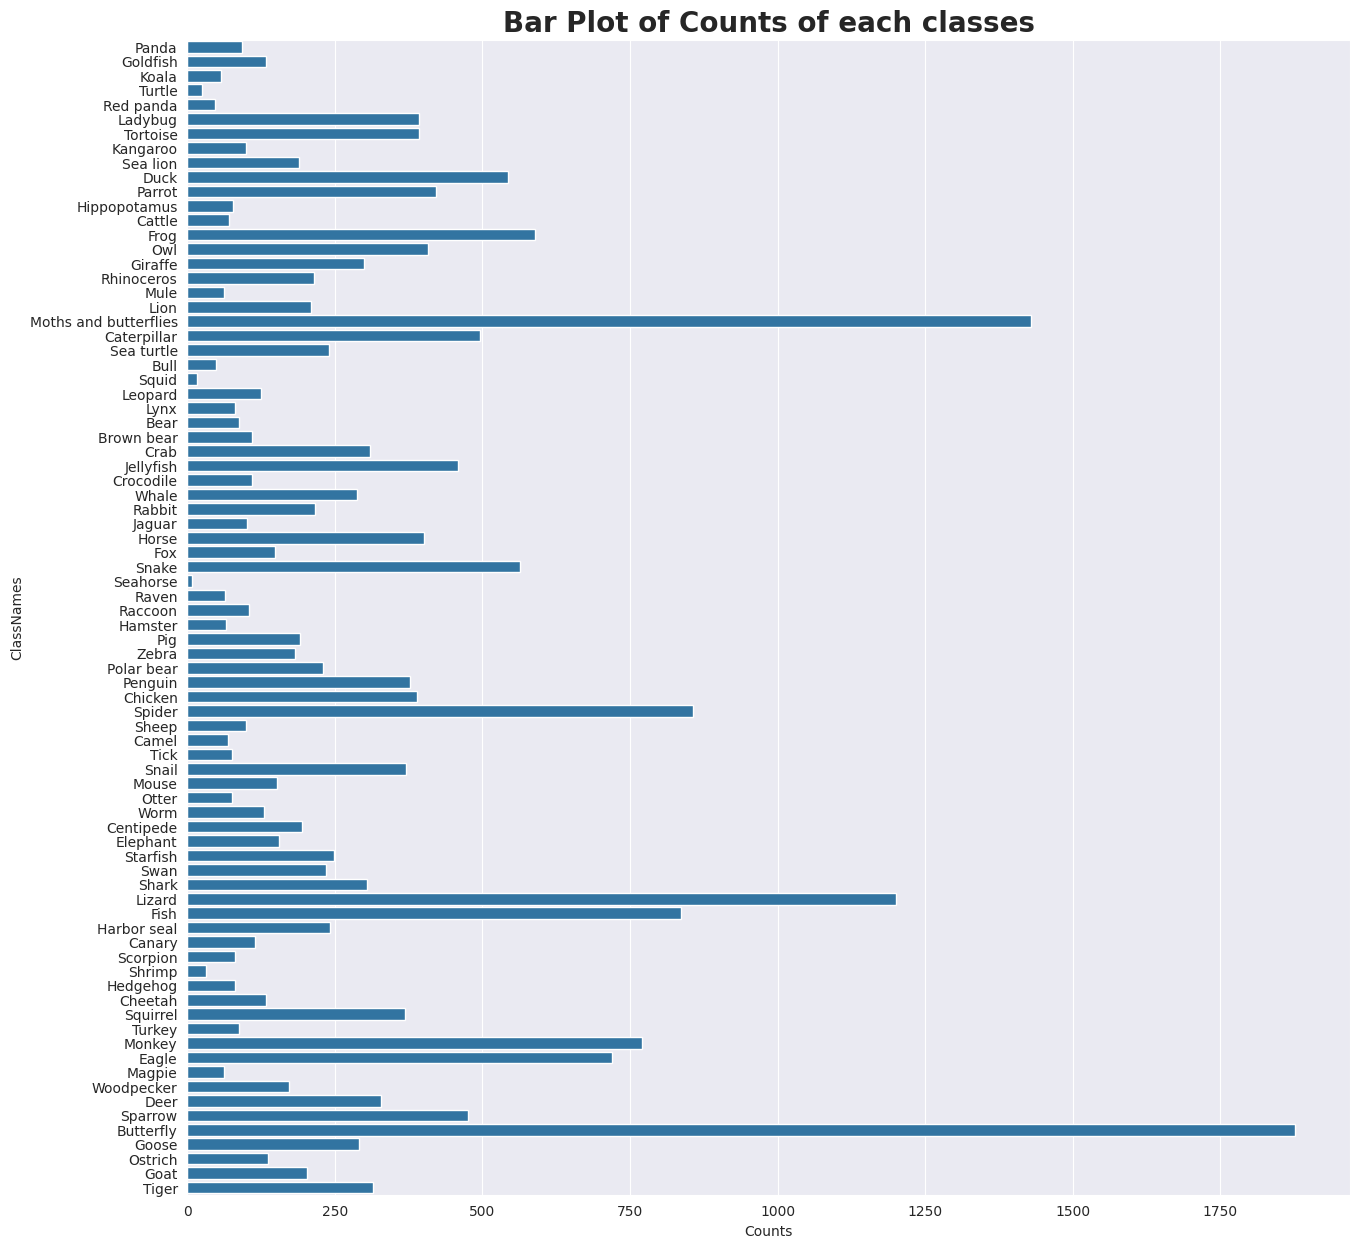

In [3]:
counts=[]
for class_name in classes :
    class_path=os.path.join(train_dir,class_name)
    count=len(os.listdir(class_path))
    counts.append((class_name,count))

counts= pd.DataFrame(counts,columns=['ClassNames','Counts'])

plt.figure(figsize=(15,15))
ax=sns.barplot(data=counts,y='ClassNames',x='Counts')
ax.set_title('Bar Plot of Counts of each classes',fontsize=20,fontweight='bold')
plt.show()

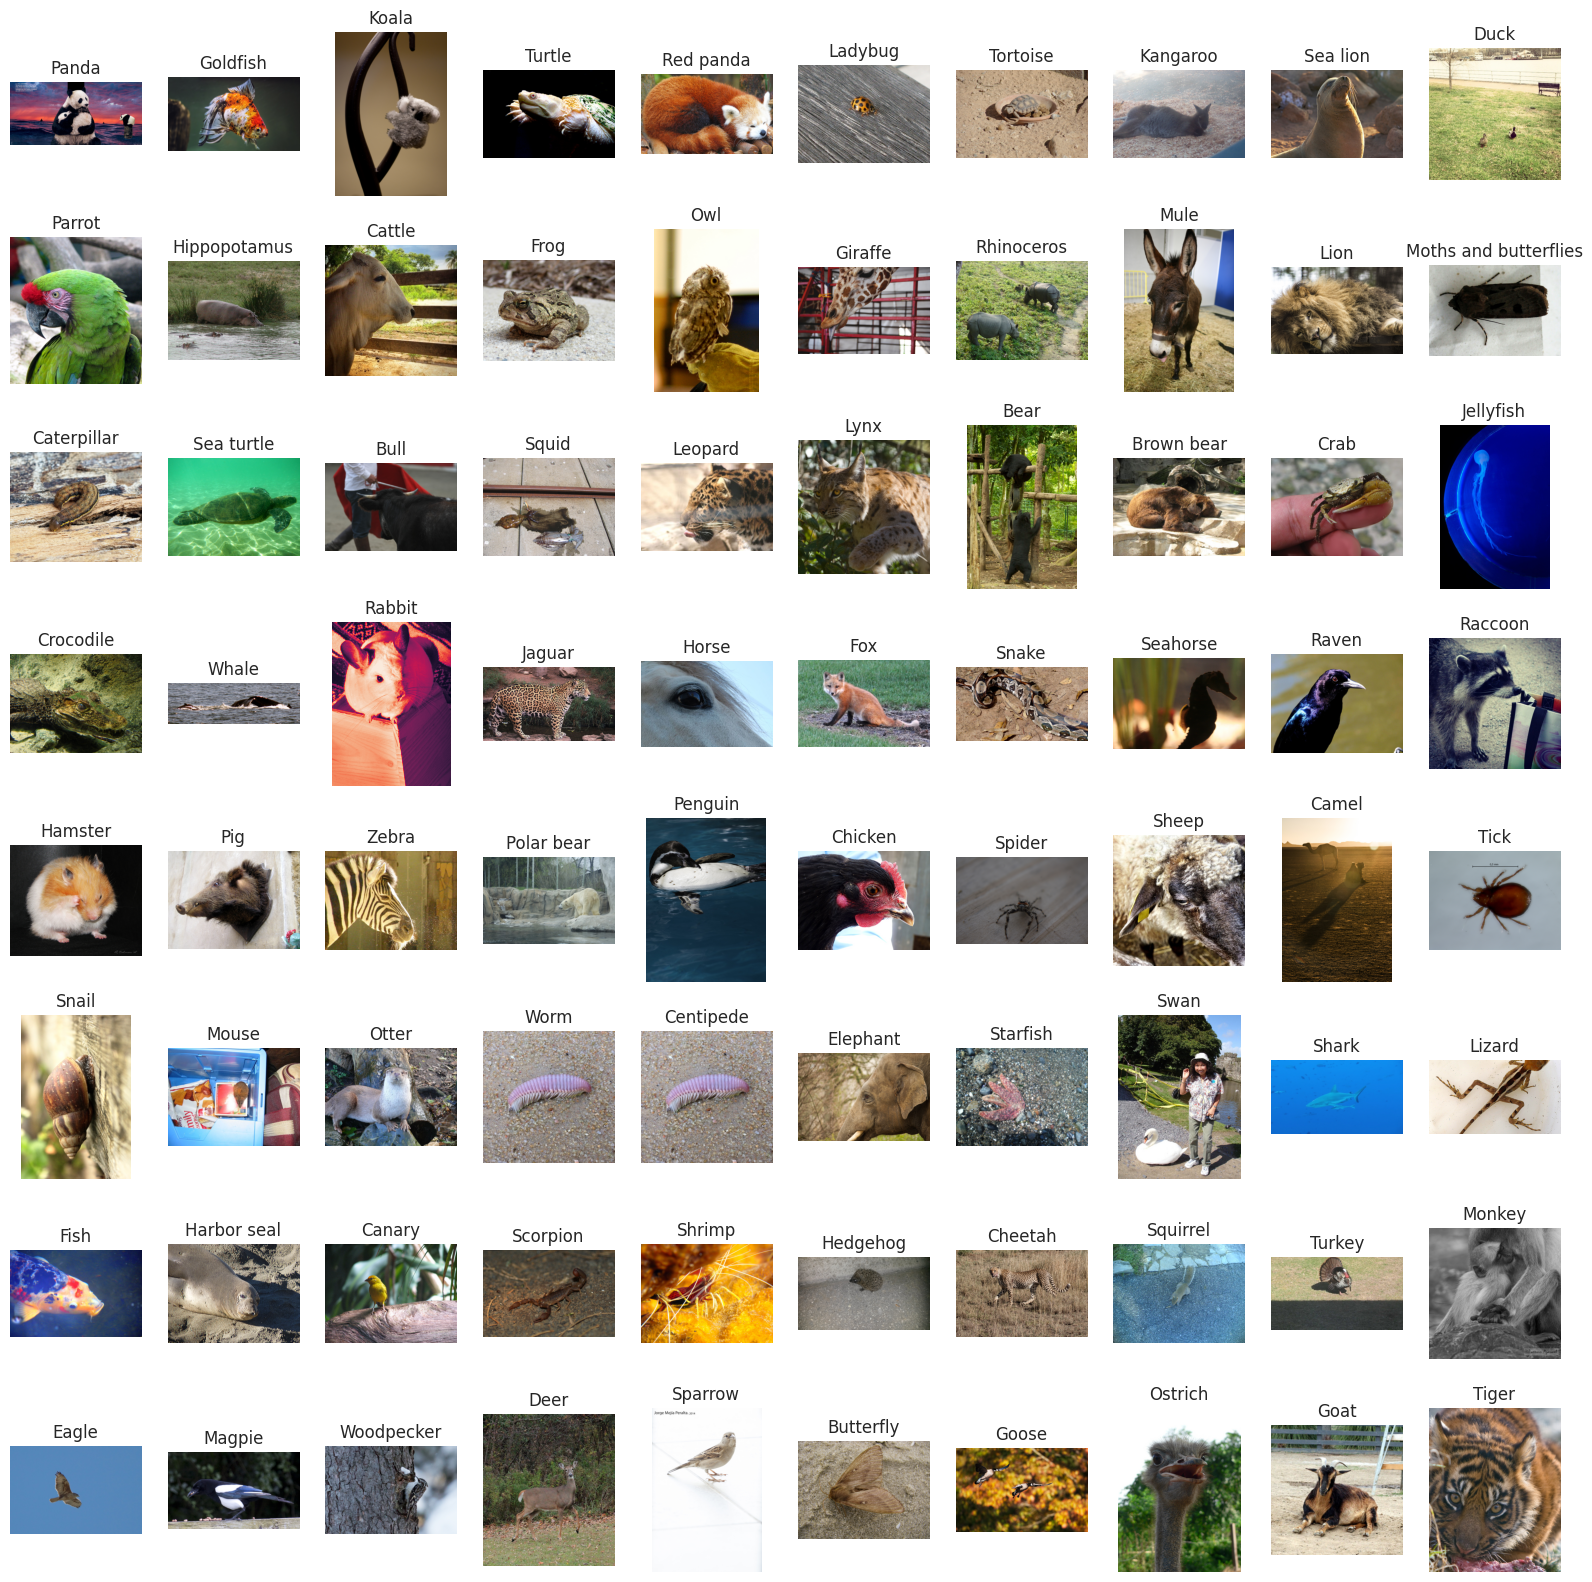

Found 22566 files belonging to 80 classes.


In [4]:
fig, ax = plt.subplots(8, 10, figsize=(20, 20))

for i in range(len(classes)) :    
    class_name = classes[i]
    class_path = os.path.join(train_dir, class_name)
    img = [file for file in os.listdir(class_path) if file.endswith('.jpg')]
    img = os.path.join(class_path, img[0])
    img = Image.open(img)
    
    col = i // 10
    row = i % 10

    ax[col, row].imshow(img)
    ax[col, row].axis('off')
    ax[col, row].set_title(class_name)
plt.show()


BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

train_full = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    seed=42,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,    
)

In [5]:
train_full = train_full.shuffle(1024).prefetch(tf.data.AUTOTUNE)
num_all_batches = len(list(train_full))
print(f'Number of all Batches : {num_all_batches}')
num_train_batches = int(num_all_batches * 0.8)
num_valid_test_batches = int(num_all_batches - num_train_batches
)
train_ds = train_full.take(num_train_batches)

remain = train_full.skip(num_train_batches)

valid_ds = remain.take(num_valid_test_batches//2)
test_ds = remain.skip(num_valid_test_batches//2)

print(f'Number of  Train  batches : {num_train_batches}')
print(f'Number of Validation batches : {num_valid_test_batches//2}')
print(f'Number of Test batches : {num_valid_test_batches//2}')

Number of all Batches : 706
Number of  Train  batches : 564
Number of Validation batches : 71
Number of Test batches : 71


In [6]:
pretrained_model = keras.applications.VGG19(
    weights='imagenet', classes=80, input_shape=(224, 224, 3), include_top=False
)
print(pretrained_model.summary())
for layer in pretrained_model.layers :
    print(layer.name)

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
pretrained_model.trainable = True               
set_trainable = False                            

for layer in pretrained_model.layers :           
    if layer.name == 'block5_conv1' :            
        set_trainable = True                     
    if set_trainable :                           
        layer.trainable = True                   
    else :                                       
        layer.trainable = False   
model = keras.models.Sequential()
model.add(pretrained_model)                              
model.add(keras.layers.Dropout(0.5))                     
model.add(keras.layers.GlobalAveragePooling2D())          
model.add(keras.layers.Flatten())                        
model.add(keras.layers.Dense(1024, activation='relu'))    
model.add(keras.layers.Dropout(0.5))                      
model.add(keras.layers.Dense(512, activation='relu'))     
model.add(keras.layers.Dropout(0.5))                     
model.add(keras.layers.Dense(80, activation='softmax'))

In [8]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('MyModel.h5', save_best_only=True) 
earlystop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00002), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_ds,                                         
    epochs=20,                                       
    validation_data=valid_ds,                         
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/20
564/564 [==============================] - 622s 1s/step - loss: 4.2957 - accuracy: 0.0668 - val_loss: 3.7370 - val_accuracy: 0.1416 - lr: 2.0000e-05
Epoch 2/20
564/564 [==============================] - 607s 1s/step - loss: 3.7281 - accuracy: 0.1549 - val_loss: 3.3272 - val_accuracy: 0.2575 - lr: 2.0000e-05
Epoch 3/20
564/564 [==============================] - 610s 1s/step - loss: 3.2947 - accuracy: 0.2530 - val_loss: 2.7397 - val_accuracy: 0.3684 - lr: 2.0000e-05
Epoch 4/20
564/564 [==============================] - 608s 1s/step - loss: 2.8870 - accuracy: 0.3462 - val_loss: 2.3613 - val_accuracy: 0.4661 - lr: 2.0000e-05
Epoch 5/20
564/564 [==============================] - 612s 1s/step - loss: 2.5007 - accuracy: 0.4304 - val_loss: 2.0028 - val_accuracy: 0.5449 - lr: 2.0000e-05
Epoch 6/20
564/564 [==============================] - 610s 1s/step - loss: 2.1675 - accuracy: 0.4981 - val_loss: 1.6518 - val_accuracy: 0.5977 - lr: 2.0000e-05
Epoch 7/20
564/564 [====================

In [9]:
model.save_weights("MyModel2.h5")

        loss  accuracy  val_loss  val_accuracy       lr
15  0.753948  0.789590  0.460561      0.877641  0.00002
16  0.695942  0.808623  0.397166      0.884683  0.00002
17  0.650504  0.815947  0.354467      0.892606  0.00002
18  0.588750  0.829986  0.307629      0.900088  0.00002
19  0.542911  0.840980  0.340749      0.903609  0.00002


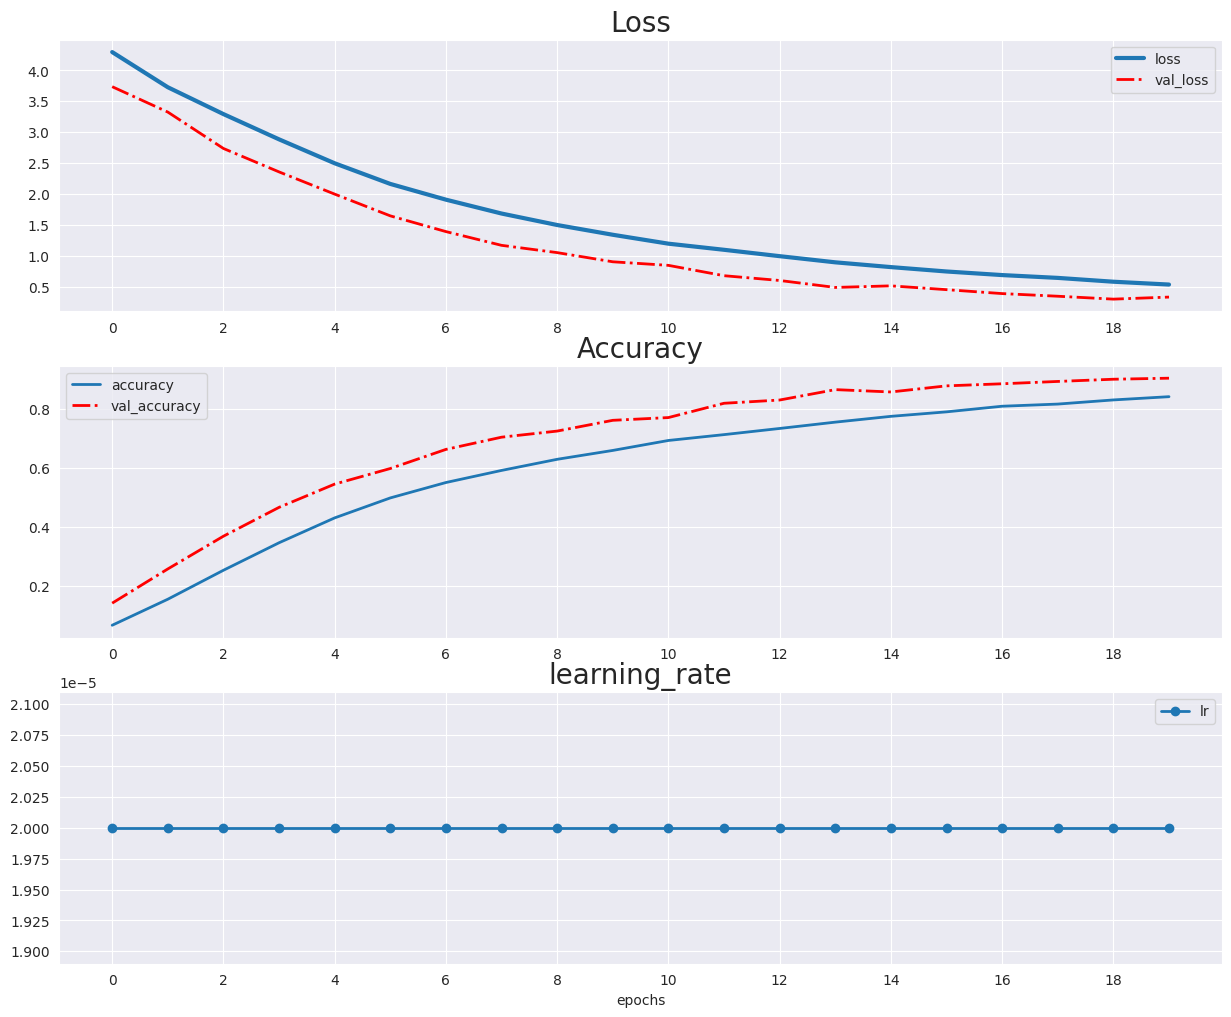

In [10]:
result_df = pd.DataFrame(history.history)
print(result_df.tail())

x = np.arange(len(result_df))


fig, ax = plt.subplots(3, 1, figsize=(15, 12))


ax[0].plot(x, result_df.loss, label='loss', linewidth=3)                          
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xticks(np.arange(0, len(x), 2))
ax[0].legend()


ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xticks(np.arange(0, len(x), 2))
ax[1].legend()


ax[2].plot(x, result_df.lr, label='lr', linewidth=2, marker='o')
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].set_xticks(np.arange(0, len(x), 2))
ax[2].legend()
plt.show()

In [11]:
best_model = keras.models.load_model('MyModel.h5')

loss, accuracy = best_model.evaluate(test_ds)
print()
print(f'Loss : {loss}')
print(f'Accuracy : {accuracy*100}')


71/71 [==============================] - 73s 816ms/step - loss: 0.3189 - accuracy: 0.8996

Loss : 0.31891587376594543
Accuracy : 89.96478915214539


1/1 [==============================] - 0s 160ms/step


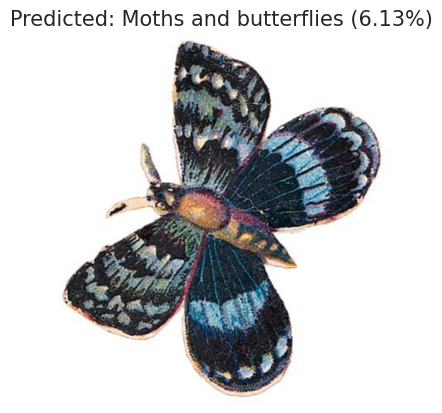


--- Top 5 Class Confidences ---
Moths and butterflies : 6.13%
Caterpillar          : 5.13%
Centipede            : 3.02%
Lizard               : 2.76%
Spider               : 2.39%

Final Prediction: Moths and butterflies (6.13%)


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
import os

model = keras.models.load_model('MyModel.h5')


class_names = os.listdir('./dataset/archive/train')


def preprocess_image(image_path, image_size=(224, 224)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(image_size)
    img_array = np.array(img).astype('float32') / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  
    return img_array


def predict_animal(image_path):
    img_array = preprocess_image(image_path)

    predictions = model.predict(img_array)[0]
    predicted_index = np.argmax(predictions)
    predicted_label = class_names[predicted_index]
    confidence = predictions[predicted_index] * 100

    img_display = Image.open(image_path)
    plt.imshow(img_display)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%)", fontsize=15)
    plt.show()

   
    print("\n--- Top 5 Class Confidences ---")
    sorted_indices = np.argsort(predictions)[::-1][:5]
    for idx in sorted_indices:
        print(f"{class_names[idx]:<20} : {predictions[idx]*100:.2f}%")

    return predicted_label, confidence


image_path = './butterfly.jpg'  
label, confidence = predict_animal(image_path)
print(f"\nFinal Prediction: {label} ({confidence:.2f}%)")
